## Preparing the data

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


In [2]:
os.chdir("C:\\Users\\brian\\Desktop\\minor\\AI project\\model")
train_data = pd.read_csv('petfinder-pawpularity-score/train.csv')
train_data['Pawpularity'] = train_data['Pawpularity']
display(train_data.head(5))

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [11]:
def load_images_from_folder(folder, data = [], size=128):
    images = []
    labels = []
    names = []
    for filename in os.listdir(folder):
        name = filename.strip('.jpg')
        names.append(name)
        labels.append(data.loc[data['Id']== name]['Pawpularity'].item())
        img = cv2.resize(cv2.imread(os.path.join(folder,filename)), (size, size))
        if img is not None:
            images.append(img)
    return np.array(images), labels, names

image_images, image_labels, image_names = load_images_from_folder('petfinder-pawpularity-score/train', data = train_data)

print(f'Training labels loaded: {image_images.shape}')

KeyboardInterrupt: 

In [4]:
image_train, image_test, label_train, label_test, name_train, name_test = train_test_split(image_images, image_labels, image_names, test_size=0.33, random_state=42)

In [5]:
print(label_train[1])
print(name_train[1])

11
7dd949718a6e4b136ac2322bf35f3c4d


## Making the model

In [6]:
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, preprocessing
import tensorflow as tf

In [7]:
def train_and_evaluate(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=20, augment={}):
    ''' Make the model to train and evaluate the data'''

    model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['RootMeanSquaredError'])

    train_gen = preprocessing.image.ImageDataGenerator(preprocess, augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(train_x)

    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y))

    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    for i, metric in enumerate(['loss', 'RootMeanSquaredError']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

    print(f"Validation Accuracy: {model.evaluate(val_gen.flow(val_x, val_y))[1]}")

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 208 steps, validate for 103 steps
Epoch 1/20
208/208 [==============================] - 11s 52ms/step - loss: 1184725.7322 - RootMeanSquaredError: 1089.5809 - val_loss: 1123.1057 - val_RootMeanSquaredError: 33.4859
Epoch 2/20
208/208 [==============================] - 9s 44ms/step - loss: 2784.3670 - RootMeanSquaredError: 52.7653 - val_loss: 614.0798 - val_RootMeanSquaredError: 24.7144
Epoch 3/20
208/208 [==============================] - 9s 45ms/step - loss: 1651.5573 - RootMeanSquaredError: 40.5656 - val_loss: 513.7929 - val_RootMeanSquaredError: 22.6022
Epoch 4/20
208/208 [==============================] - 9s 44ms/step - loss: 1211.0659 - RootMeanSquaredError: 34.7974 - val_loss: 885.6277 - val_RootMeanSquaredError: 29.7218
Epoch 5/20
208/208 [==============================] - 9s 44ms/step - loss: 940.6489 - RootMeanSquaredError: 30.6520 - val_loss: 1187.1764 - val_RootMeanSquaredError: 34.3804
Epoch 6/20
208/208 [=========

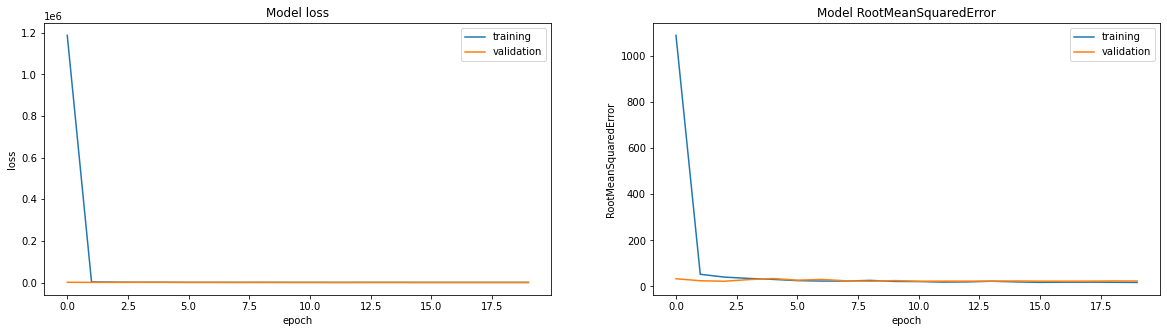

  ...
    to  
  ['...']
103/103 [==============================] - 1s 8ms/step - loss: 557.5319 - RootMeanSquaredError: 23.6701
Validation Accuracy: 23.67011070251465


In [8]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=(128,128,3),padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512,activation='relu'))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dense(1,activation=None))

# train the model and evaluate it with the test_data
train_and_evaluate(model, image_train, label_train, image_test, label_test, epochs=20)

In [9]:
test_images = []

test_names = []
for filename in os.listdir('petfinder-pawpularity-score/test'):
    name = filename.strip('.jpg')
    test_names.append(name)
    img = cv2.imread(os.path.join('petfinder-pawpularity-score/test',filename))
    if img is not None:
        test_images.append(img)

In [10]:
test_images = np.array(test_images)
model.predict(test_images)

array([[71.59759 ],
       [75.476135],
       [70.961464],
       [64.8789  ],
       [67.95618 ],
       [54.87404 ],
       [70.4556  ],
       [63.27196 ]], dtype=float32)